Download this notebook from [https://raw.githubusercontent.com/daniel-acuna/python_data_science_intro/master/notebooks/lab-sentiment_analysis.ipynb](https://raw.githubusercontent.com/daniel-acuna/python_data_science_intro/master/notebooks/lab-sentiment_analysis.ipynb)

# Introduction to Spark ML: An application to Sentiment Analysis

# Spark ML

In previous versions of Spark, most Machine Learning funcionality was provided through RDD (Resilient Distributed Datasets). However, to improve performance and communicability of results, Spark developers ported the ML functionality to work almost exclusively with DataFrames. Future releases of Spark will not update the support of ML with RDDs.

In this modern Spark ML approach, there are _Estimators_ and _Transformers_. Estimators have some parameters that need to be fit into the data. After fitting, Estimators return Transformers. Tranformers can be applied to dataframes, taking one (or several) columns as input and creating (or several) columns as output.

A _Pipeline_ combines several _Tranformers_ with a final _Estimator_. The _Pipeline_, therefore, can be fit to the data because the final step of the process (the _Estimator_) is fit to the data. The result of the fitting is a pipelined _Transformer_ that takes an input dataframe through all the stages of the Pipeline.

There is a third type of functionality that allows to select features.

For example, for analyzing text, a typical pipelined estimator is as follows:

<img src="http://spark.apache.org/docs/latest/img/ml-Pipeline.png" alt="ML Pipeline" style="width: 100%;"/>

After fitting, the Pipeline becomes a transformer:

<img src="http://spark.apache.org/docs/latest/img/ml-PipelineModel.png" alt="ML Model" style="width: 100%;"/>
(Images from http://spark.apache.org/docs/latest/ml-pipeline.html)

Importantly, transformers can be saved and exchanged with other data scientists, improving reproducibility.

## Loading packages and connecting to Spark cluster

In [1]:
import findspark

In [2]:
findspark.init()

In [3]:
import pyspark
import numpy as np

```
conf = pyspark.SparkConf().\
    setAppName('sentiment-analysis').\
    setMaster('local[*]')

from pyspark.sql import SQLContext, HiveContext
sc = pyspark.SparkContext(conf=conf)
sqlContext = HiveContext(sc)
```

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder\
    .appName("sentiment-analysis")\
    .getOrCreate()

In [7]:
sc = spark.sparkContext

In [8]:
from pyspark.sql import SQLContext, HiveContext
sqlContext = HiveContext(sc)

In [9]:
# dataframe functions
from pyspark.sql import functions as fn

## Introduction to dataframes

A `DataFrame` is a relatively new addition to Spark that stores a distributed dataset of structured columns. It is very similar to an R dataframe or a RDBS table. All columns are of the same type. A `DataFrame` can be constructed out of a variety of sources, such as a database, CSV files, JSON files, or a Parquet file (columnar storage). The preferred method for storing dataframes is Parquet due to its speed and compression ratio.

### Manipulating a DataFrame

We can create a dataframe from a RDD using the `sqlContext`.

In [10]:
# Create a RDDs
documents_rdd = sc.parallelize([
        [1, 'cats are cute', 0],
        [2, 'dogs are playfull', 0],
        [3, 'lions are big', 1],
        [4, 'cars are fast', 1]])

users_rdd = sc.parallelize([
        [0, 'Alice', 20],
        [1, 'Bob', 23],
        [2, 'Charles', 32]])

From the previous RDDs, we can call the `toDF` method and specify the name of columns:

In [11]:
documents_df = documents_rdd.toDF(['doc_id', 'text', 'user_id'])
users_df = users_rdd.toDF(['user_id', 'name', 'age'])

Spark will automatically try to guess the column types. We can take a look at those types:

In [12]:
documents_df.printSchema()

root
 |-- doc_id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: long (nullable = true)



In [13]:
users_df.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)



In [14]:
users_df.show()

+-------+-------+---+
|user_id|   name|age|
+-------+-------+---+
|      0|  Alice| 20|
|      1|    Bob| 23|
|      2|Charles| 32|
+-------+-------+---+



In [15]:
documents_df.show()

+------+-----------------+-------+
|doc_id|             text|user_id|
+------+-----------------+-------+
|     1|    cats are cute|      0|
|     2|dogs are playfull|      0|
|     3|    lions are big|      1|
|     4|    cars are fast|      1|
+------+-----------------+-------+



Similar to SQL, we can apply a function to a column or several columns.

In [11]:
from pyspark.sql import functions as fn

In [16]:
# compute the average age of users
user_age_df = users_df.select(fn.avg('age'))
user_age_df

DataFrame[avg(age): double]

As you can see, the function is not evaluated until an _action_ (e.g., `take`, `show`, `collect`) is taken

In [17]:
user_age_df.show()

+--------+
|avg(age)|
+--------+
|    25.0|
+--------+



We can cross (e.g., join) two dataframes _ala_ SQL

In [18]:
users_df.join(documents_df, on='user_id').show()

+-------+-----+---+------+-----------------+
|user_id| name|age|doc_id|             text|
+-------+-----+---+------+-----------------+
|      0|Alice| 20|     1|    cats are cute|
|      0|Alice| 20|     2|dogs are playfull|
|      1|  Bob| 23|     3|    lions are big|
|      1|  Bob| 23|     4|    cars are fast|
+-------+-----+---+------+-----------------+



We can also do outer joins

In [19]:
users_df.join(documents_df, on='user_id', how='left').show()

+-------+-------+---+------+-----------------+
|user_id|   name|age|doc_id|             text|
+-------+-------+---+------+-----------------+
|      0|  Alice| 20|     1|    cats are cute|
|      0|  Alice| 20|     2|dogs are playfull|
|      1|    Bob| 23|     3|    lions are big|
|      1|    Bob| 23|     4|    cars are fast|
|      2|Charles| 32|  null|             null|
+-------+-------+---+------+-----------------+



We can apply group functions

In [20]:
users_df.join(documents_df, 'user_id', how='left').\
    groupby('user_id', 'name').\
    agg(fn.count('text')).\
    show()

+-------+-------+-----------+
|user_id|   name|count(text)|
+-------+-------+-----------+
|      0|  Alice|          2|
|      1|    Bob|          2|
|      2|Charles|          0|
+-------+-------+-----------+



We can change the name of computed columns:

In [21]:
users_df.join(documents_df, 'user_id', how='left').\
    groupby('user_id', 'name').\
    agg(fn.count('text').alias('n_pets')).\
    show()

+-------+-------+------+
|user_id|   name|n_pets|
+-------+-------+------+
|      0|  Alice|     2|
|      1|    Bob|     2|
|      2|Charles|     0|
+-------+-------+------+



Add columns:

In [22]:
users_df.withColumn('name_length', fn.length('name')).show()

+-------+-------+---+-----------+
|user_id|   name|age|name_length|
+-------+-------+---+-----------+
|      0|  Alice| 20|          5|
|      1|    Bob| 23|          3|
|      2|Charles| 32|          7|
+-------+-------+---+-----------+



There are many, many types of functions. E.g., [see here](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions)

### Transformers and Estimators

There are several ways of transforming the data from raw input to something that can be analyzed with a statistical model.

Some examples of such transformers are displayed below:

#### Tokenizer

Suppose that we want to split the words or _tokens_ of a document. This is what `Tokenizer` does.

In [23]:
from pyspark.ml.feature import Tokenizer

Almost all transfomers and estimator require you to specificy the input column of the dataframe and the output column that will be added to the dataframe.

In [24]:
# the tokenizer object
tokenizer = Tokenizer().setInputCol('text').setOutputCol('words')

We can now transform the dataframe

In [25]:
tokenizer.transform(documents_df).show(10,False)

+------+-----------------+-------+---------------------+
|doc_id|text             |user_id|words                |
+------+-----------------+-------+---------------------+
|1     |cats are cute    |0      |[cats, are, cute]    |
|2     |dogs are playfull|0      |[dogs, are, playfull]|
|3     |lions are big    |1      |[lions, are, big]    |
|4     |cars are fast    |1      |[cars, are, fast]    |
+------+-----------------+-------+---------------------+



#### CountVectorizer

This transformer counts how many times a word appears in a list and produces a vector with such counts. This is very useful for text analysis.

In [22]:
from pyspark.ml.feature import CountVectorizer

A `CountVectorizer` is different from a `Tokenizer` because it needs to learn how many different tokens there are in the input column. With that number, it will output vectors with consistent dimensions. Therefore, `CountVectorizer` is an `Estimator` that, when fitted, returns a `Transformer`.

In [23]:
count_vectorizer_estimator = CountVectorizer().setInputCol('words').setOutputCol('features')

Now we need to user the words column that  generated by the `tokenizer` transformer

In [24]:
count_vectorizer_transformer = count_vectorizer_estimator.fit(tokenizer.transform(documents_df))

which results in:

In [25]:
count_vectorizer_transformer.transform(tokenizer.transform(documents_df)).show(truncate=False)

+------+-----------------+-------+---------------------+-------------------------+
|doc_id|text             |user_id|words                |features                 |
+------+-----------------+-------+---------------------+-------------------------+
|1     |cats are cute    |0      |[cats, are, cute]    |(9,[0,3,5],[1.0,1.0,1.0])|
|2     |dogs are playfull|0      |[dogs, are, playfull]|(9,[0,2,7],[1.0,1.0,1.0])|
|3     |lions are big    |1      |[lions, are, big]    |(9,[0,1,6],[1.0,1.0,1.0])|
|4     |cars are fast    |1      |[cars, are, fast]    |(9,[0,4,8],[1.0,1.0,1.0])|
+------+-----------------+-------+---------------------+-------------------------+



The column `features` is a sparse vector representation. For example, for the first document, we have three features present: 0, 3, and 5. By looking at the vocabulary learned by `count_vectorizer_transformer`, we can know which words those feature indices refer to:

In [26]:
# list of words in the vocabulary
count_vectorizer_transformer.vocabulary

['are', 'big', 'playfull', 'cute', 'fast', 'cats', 'lions', 'dogs', 'cars']

In [27]:
np.array(count_vectorizer_transformer.vocabulary)[[0, 3, 5]]

array(['are', 'cute', 'cats'], 
      dtype='<U8')

## Pipelines

Sometimes, we have long preprocessing steps that take raw data and transform it through several stages. As explained before, these complex transformations can be captured by Pipelines.

Pipelines are always estimators, even when they contain several transformers. After a pipeline is `fit` to the data, the pipeline becomes an transformer.

We will now define a pipeline that takes the raw `text` column and produces the `features` column previously explained

In [28]:
from pyspark.ml import Pipeline

In [29]:
pipeline_cv_estimator = Pipeline(stages=[tokenizer, count_vectorizer_estimator])

In [30]:
pipeline_cv_transformer = pipeline_cv_estimator.fit(documents_df)

In [31]:
pipeline_cv_transformer.transform(documents_df).show()

+------+-----------------+-------+--------------------+--------------------+
|doc_id|             text|user_id|               words|            features|
+------+-----------------+-------+--------------------+--------------------+
|     1|    cats are cute|      0|   [cats, are, cute]|(9,[0,3,5],[1.0,1...|
|     2|dogs are playfull|      0|[dogs, are, playf...|(9,[0,2,7],[1.0,1...|
|     3|    lions are big|      1|   [lions, are, big]|(9,[0,1,6],[1.0,1...|
|     4|    cars are fast|      1|   [cars, are, fast]|(9,[0,4,8],[1.0,1...|
+------+-----------------+-------+--------------------+--------------------+



In more complex scenarios, you can even chain Pipeline transformers. We will see this case in the actual use case below.

For a more detail explanation of Pipelines, Estimators, and Transformers, [see here](http://spark.apache.org/docs/latest/ml-pipeline.html)

## Download the review, sentiment, and tweet datasets

In [32]:
!wget https://github.com/daniel-acuna/python_data_science_intro/blob/master/data/imdb_reviews_preprocessed.parquet.zip?raw=true -O imdb_reviews_preprocessed.parquet.zip && unzip imdb_reviews_preprocessed.parquet.zip && rm imdb_reviews_preprocessed.parquet.zip

--2016-10-25 01:17:09--  https://github.com/daniel-acuna/python_data_science_intro/blob/master/data/imdb_reviews_preprocessed.parquet.zip?raw=true
Resolving github.com... 192.30.253.112, 192.30.253.113
Connecting to github.com|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/daniel-acuna/python_data_science_intro/raw/master/data/imdb_reviews_preprocessed.parquet.zip [following]
--2016-10-25 01:17:10--  https://github.com/daniel-acuna/python_data_science_intro/raw/master/data/imdb_reviews_preprocessed.parquet.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/daniel-acuna/python_data_science_intro/master/data/imdb_reviews_preprocessed.parquet.zip [following]
--2016-10-25 01:17:10--  https://raw.githubusercontent.com/daniel-acuna/python_data_science_intro/master/data/imdb_reviews_preprocessed.parquet.zip
Resolving raw.githubusercont

In [33]:
!wget https://github.com/daniel-acuna/python_data_science_intro/blob/master/data/sentiments.parquet.zip?raw=true -O sentiments.parquet.zip && unzip sentiments.parquet.zip && rm sentiments.parquet.zip

--2016-10-25 01:17:14--  https://github.com/daniel-acuna/python_data_science_intro/blob/master/data/sentiments.parquet.zip?raw=true
Resolving github.com... 192.30.253.112, 192.30.253.113
Connecting to github.com|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/daniel-acuna/python_data_science_intro/raw/master/data/sentiments.parquet.zip [following]
--2016-10-25 01:17:14--  https://github.com/daniel-acuna/python_data_science_intro/raw/master/data/sentiments.parquet.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/daniel-acuna/python_data_science_intro/master/data/sentiments.parquet.zip [following]
--2016-10-25 01:17:14--  https://raw.githubusercontent.com/daniel-acuna/python_data_science_intro/master/data/sentiments.parquet.zip
Resolving raw.githubusercontent.com... 151.101.44.133
Connecting to raw.githubusercontent.com|151.101.4

In [34]:
!wget https://github.com/daniel-acuna/python_data_science_intro/blob/master/data/tweets.parquet.zip?raw=true -O tweets.parquet.zip && unzip tweets.parquet.zip && rm tweets.parquet.zip

--2016-10-25 01:17:15--  https://github.com/daniel-acuna/python_data_science_intro/blob/master/data/tweets.parquet.zip?raw=true
Resolving github.com... 192.30.253.112, 192.30.253.113
Connecting to github.com|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/daniel-acuna/python_data_science_intro/raw/master/data/tweets.parquet.zip [following]
--2016-10-25 01:17:15--  https://github.com/daniel-acuna/python_data_science_intro/raw/master/data/tweets.parquet.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/daniel-acuna/python_data_science_intro/master/data/tweets.parquet.zip [following]
--2016-10-25 01:17:15--  https://raw.githubusercontent.com/daniel-acuna/python_data_science_intro/master/data/tweets.parquet.zip
Resolving raw.githubusercontent.com... 151.101.44.133
Connecting to raw.githubusercontent.com|151.101.44.133|:443... connec

## Load sentiment data

In [27]:
sentiments_df = spark.read.parquet('../data/sentiments.parquet')

sentiments_df = sqlContext.read.parquet('sentiments.parquet')

In [28]:
sentiments_df.printSchema()

root
 |-- word: string (nullable = true)
 |-- sentiment: long (nullable = true)



In [29]:
sentiments_df.show(3,False)

+-------------+---------+
|word         |sentiment|
+-------------+---------+
|gratefully   |1        |
|gratification|1        |
|gratified    |1        |
+-------------+---------+
only showing top 3 rows



The schema is very simple: for each word, we have whether it is positive (+1) or negative (-1)

In [30]:
# a sample of positive words
sentiments_df.where(fn.col('sentiment') == 1).show(5)

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



In [31]:
# a sample of negative words
sentiments_df.where(fn.col('sentiment') == -1).show(5)

+----------+---------+
|      word|sentiment|
+----------+---------+
|   2-faced|       -1|
|   2-faces|       -1|
|  abnormal|       -1|
|   abolish|       -1|
|abominable|       -1|
+----------+---------+
only showing top 5 rows



Lets see how many of each category we have

In [32]:
sentiments_df.groupBy('sentiment').agg(fn.count('*')).show()

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|        1|    2006|
|       -1|    4783|
+---------+--------+



We have almost two times the number of negative words!

# A simple approach to sentiment analysis

One simple approach for sentiment analysis is to simple count the number of positive and negative words in a text and then compute the average sentiment. Assuming that positive words are +1 and negative words are -1, we can classify a text as positive if the average sentiment is greater than zero and negative otherwise

To test our approach, we will use a sample of [IMDB](http://www.imdb.com/) reviews that were tagged as positive and negative.

Let's load them:

In [33]:
imdb_reviews_df = sqlContext.read.parquet('../data/imdb_reviews_preprocessed.parquet')

imdb_reviews_df = sqlContext.read.parquet('imdb_reviews_preprocessed.parquet')

In [35]:
imdb_reviews_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- review: string (nullable = true)
 |-- score: double (nullable = true)



In [34]:
imdb_reviews_df.show(5,False)

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Let's take a look at a positive review

In [36]:
imdb_reviews_df.where(fn.col('score') == 1).first()

Row(id='pos_10006', review='In this "critically acclaimed psychological thriller based on true events, Gabriel (Robin Williams), a celebrated writer and late-night talk show host, becomes captivated by the harrowing story of a young listener and his adoptive mother (Toni Collette). When troubling questions arise about this boy\'s (story), however, Gabriel finds himself drawn into a widening mystery that hides a deadly secret\x85" according to film\'s official synopsis.<br /><br />You really should STOP reading these comments, and watch the film NOW...<br /><br />The "How did he lose his leg?" ending, with Ms. Collette planning her new life, should be chopped off, and sent to "deleted scenes" land. It\'s overkill. The true nature of her physical and mental ailments should be obvious, by the time Mr. Williams returns to New York. Possibly, her blindness could be in question - but a revelation could have be made certain in either the "highway" or "video tape" scenes. The film would benefi

And a negative one

In [37]:
imdb_reviews_df.where(fn.col('score') == 0).first()

Row(id='neg_10006', review="I don't know who to blame, the timid writers or the clueless director. It seemed to be one of those movies where so much was paid to the stars (Angie, Charlie, Denise, Rosanna and Jon) that there wasn't enough left to really make a movie. This could have been very entertaining, but there was a veil of timidity, even cowardice, that hung over each scene. Since it got an R rating anyway why was the ubiquitous bubble bath scene shot with a 70-year-old woman and not Angie Harmon? Why does Sheen sleepwalk through potentially hot relationships WITH TWO OF THE MOST BEAUTIFUL AND SEXY ACTRESSES in the world? If they were only looking for laughs why not cast Whoopi Goldberg and Judy Tenuta instead? This was so predictable I was surprised to find that the director wasn't a five year old. What a waste, not just for the viewers but for the actors as well.", score=0.0)

The first problem that we encounter is that the reviews are in plain text. We need to split the words and then match them to `sentiment_df`.

To do, we will use a transformation that takes raw text and outputs a list of words

In [38]:
from pyspark.ml.feature import RegexTokenizer

`RegexTokenizer` extracts a sequence of matches from the input text. Regular expressions are a powerful tool to extract strings with certain characteristics.

In [39]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("review")\
  .setOutputCol("words")

The pattern `\p{L}+` means that it will extract letters without accents (e.g., it will extract "Acuna" from "Acuña"). `setGaps` means that it will keep applying the rule until it can't extract new words. You have to set the input column from the incoming dataframe (in our case the `review` column) and the new column that will be added (e.g., `words`).

We are ready to transform the input dataframe `imdb_reviews_df` with the tokenizer:

In [40]:
review_words_df = tokenizer.transform(imdb_reviews_df)
print(review_words_df)

DataFrame[id: string, review: string, score: double, words: array<string>]


Applying the transformation doesn't actually do anything until you apply an action. But as you can see, a new column `words` of type `array` of `string` was added by the transformation. We can see how it looks:

In [41]:
review_words_df.show(5)

+---------+--------------------+-----+--------------------+
|       id|              review|score|               words|
+---------+--------------------+-----+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|
+---------+--------------------+-----+--------------------+
only showing top 5 rows



In [42]:
review_words_df.show(1, False)

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now, we want to match every word from `sentiment_df` in the array `words` shown before. One way of doing this is to _explode_ the column `words` to create a row for each element in that list. Then, we would join that result with the dataframe `sentiment` to continue further.

In [43]:
review_words_df.select('id', fn.explode('words').alias('word')).show(5)

+---------+-------------+
|       id|         word|
+---------+-------------+
|pos_10006|           in|
|pos_10006|         this|
|pos_10006|   critically|
|pos_10006|    acclaimed|
|pos_10006|psychological|
+---------+-------------+
only showing top 5 rows



Now if we join that with sentiment, we can see if there are positive and negative words in each review:

In [44]:
review_word_sentiment_df = review_words_df.\
    select('id', fn.explode('words').alias('word')).\
    join(sentiments_df, 'word')
review_word_sentiment_df.show(5)

+----------+---------+---------+
|      word|       id|sentiment|
+----------+---------+---------+
| acclaimed|pos_10006|        1|
|celebrated|pos_10006|        1|
| troubling|pos_10006|       -1|
|   mystery|pos_10006|       -1|
|    deadly|pos_10006|       -1|
+----------+---------+---------+
only showing top 5 rows



Now we can simply average the sentiment per review id and, say, pick positive when the average is above 0, and negative otherwise.

In [45]:
simple_sentiment_prediction_df = review_word_sentiment_df.\
    groupBy('id').\
    agg(fn.avg('sentiment').alias('avg_sentiment')).\
    withColumn('predicted', fn.when(fn.col('avg_sentiment') > 0, 1.0).otherwise(0.))
simple_sentiment_prediction_df.show(5)

+---------+--------------------+---------+
|       id|       avg_sentiment|predicted|
+---------+--------------------+---------+
|pos_10149| 0.42857142857142855|      1.0|
|pos_10377|  0.5384615384615384|      1.0|
| pos_1299| 0.09090909090909091|      1.0|
| pos_2228|-0.14285714285714285|      0.0|
| pos_5052|  0.7777777777777778|      1.0|
+---------+--------------------+---------+
only showing top 5 rows



Now, lets compute the accuracy of our prediction

In [46]:
imdb_reviews_df.\
    join(simple_sentiment_prediction_df, 'id').\
    select(fn.expr('float(score = predicted)').alias('correct')).\
    select(fn.avg('correct')).\
    show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.732231471106131|
+-----------------+



Not bad with such a simple approach! But can we do better than this?

## A data-driven sentiment prediction

There are couple of problems with the previous approach:
1. Positive and negative words had the same weight (e.g., good == amazing)
1. Maybe a couple of negative words make the entire review negative, whereas positive words do not
1. While our dataset is artificially balanced (12500 positive and 12500 negative), there are usually more positive than negative reviews, and therefore we should bias our predictions towards positive ones.

We could use __data__ to estimate the sentiment that each word is contributing to the final sentiment of a review. Given that we are trying to predict negative and positve reviews, then we can use logistic regression for such binary prediction.

### From text to numerical features

One typical approach is to count how many times a word appears in the text and then perform a reweighting so that words that are very common are "counted" less.

In Spark, we can achieve this by using several transformers:

__Raw text => Tokens => Remove stop words => Term Frequency => Reweighting by Inverse Document frequency__

To perform this sequence we will create a __`Pipeline`__ to consistently represent the steps from raw text to TF-IDF.

First, we need to create a sequence to take from raw text to term frequency. This is necessary because we don't know the number of tokens in the text and therefore we need to _estimate_ such quantity from the data.

In [51]:
# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [52]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

Finally, for this initial `Pipeline`, we define a counter vectorizer estimator

In [53]:
from pyspark.ml.feature import CountVectorizer

# we will remove words that appear in 5 docs or less
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [54]:
# we now create a pipelined transformer
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(imdb_reviews_df)

In [55]:
# now we can make the transformation between the raw text and the counts
cv_pipeline.transform(imdb_reviews_df).show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
|pos_10008|You know, Robin W...|  1.0|[you, know, robin...|[know, robin, wil...|(26677,[0,1,2,3,4...|
|pos_10015|Popular radio sto...|  1.0|[popular, radio, ...|[popular, radio, ...|(26677,[0,1,2,3,4...|
|pos_10024|There's so many t...|  1.0|[there, s, so, ma...|[s, things, fall,...|(26677,[0,1,2,4,5...|
|pos_10026|Without Kirsten M...|  1.0|[without, kirsten...|[kirsten, miller,...|(26677,[1,3,4,23,...|
|pos_10035|I think James Cam...|  1.0|[i, think, james,...|[think, james, ca...|(26677,[0,2,3,6,7...|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



The term frequency vector is represented with a sparse vector. We have 26,384 terms.

Finally, we build another pipeline that takes the output of the previous pipeline and _lowers_ the terms of documents that are very common.

In [56]:
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [57]:
idf_pipeline = Pipeline(stages=[cv_pipeline, idf]).fit(imdb_reviews_df)

In [58]:
idf_pipeline.transform(imdb_reviews_df).show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|               tfidf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|pos_10008|You know, Robin W...|  1.0|[you, know, robin...|[know, robin, wil...|(26677,[0,1,2,3,4...|(26677,[0,1,2,3,4...|
|pos_10015|Popular radio sto...|  1.0|[popular, radio, ...|[popular, radio, ...|(26677,[0,1,2,3,4...|(26677,[0,1,2,3,4...|
|pos_10024|There's so many t...|  1.0|[there, s, so, ma...|[s, things, fall,...|(26677,[0,1,2,4,5...|(26677,[0,1,2,4,5...|
|pos_10026|Without Kirsten M...|  1.0|[without, kirsten...|[kirsten, miller,...|(26677,[1,3,4,23,...|(26677,[1,3,4,23,...|
|pos_10035|I think James Cam...|  1.0|[i, think, james,...|[think, james, ca...|(26677,[0,2,3,6,7...|(26677,[0,2,3,6,7...|
+---------+-----

Therefore, the `idf_pipeline` takes the raw text from the datafarme `imdb_reviews_df` and creates a feature vector vector called `tfidf`!

In [59]:
tfidf_df = idf_pipeline.transform(imdb_reviews_df)

# Data science pipeline for estimating sentiments

First, let's split the data into training, validation, and testing.

In [60]:
training_df, validation_df, testing_df = imdb_reviews_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [61]:
[training_df.count(), validation_df.count(), testing_df.count()]

[15085, 7347, 2568]

One immediately apparent problem is that the number of features in the dataset is far larger than the number of training examples. This can lead to serious overfitting.

Let's look at this more closely. Let's apply a simple prediction model known as logistic regression.

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) will take the `tfidf` features and predict whether the review is positive (`score == 1`) or negative (`score == 0`).

In [62]:
from pyspark.ml.classification import LogisticRegression

In [63]:
lr = LogisticRegression().\
    setLabelCol('score').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

Lets create a pipeline transformation by chaining the `idf_pipeline` with the logistic regression step (`lr`)

In [64]:
lr_pipeline = Pipeline(stages=[idf_pipeline, lr]).fit(training_df)

Lets estimate the accuracy:

In [65]:
lr_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = score)').alias('correct')).\
    select(fn.avg('correct')).show()

/Users/danielacuna/Downloads/spark-1.6.1-bin-hadoop2.6/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+------------------+
|      avg(correct)|
+------------------+
|0.8395263372805226|
+------------------+



The performance is much better than before.

The problem however is that we are overfitting because we have many features compared to the training examples:

For example, if we look at the weights of the features, there is a lot of noise:

In [66]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})

The most negative words are:

In [67]:
coeffs_df.sort_values('weight').head(5)

,weight,word
26363,-7.376168,octane
15790,-6.044970,waster
24190,-5.310334,civility
22733,-5.182578,necessities
26432,-4.881442,collete


And the most positive:

In [68]:
coeffs_df.sort_values('weight', ascending=False).head(5)

,weight,word
25089,7.635574,appreciable
25693,7.076770,enlarged
21021,6.458757,screenwriting
22134,5.394323,sandwiched
11673,4.549058,ringwald


But none of them make sense. What is happening? We are overfitting the data. Those words that don't make sense are capturing just noise in the reviews.

For example, the word `helming` appears in only one review:

In [69]:
idf_pipeline.transform(training_df).\
    select('id', fn.explode('words').alias('word')).\
    where(fn.col('word') == 'helming').\
    join(training_df, 'id').\
    first()

Row(id='neg_899', word='helming', review='On the 1998 summer blockbuster hit BASEketball (1998): "This is one of those movies that is usually seen on the big jumbo-tron screen in a sports bar during the day - when everyone is quite drunk. Unfortunately, I was sober when I saw this movie."<br /><br />So quoted the late Gene Siskel for this lame-brained, supposed yukfest that came out two weeks after the far superior "There\'s Something About Mary" in a one-upmanship game during July of 1998. "Mary" was a gross-out fest, but in addition to the many gags, it had a lot of heart, which is why it was the highest grossing comedy of that memorable summer.<br /><br />"BASEketball" tried to outdo Mary, but it fizzled in more ways that one. You take the creators of "South Park," Trey Parker and Matt Stone, who are fortunately not behind the movie but in front of the camera, the only member of ZAZ David Zucker helming the picture in desperate need of a paycheck, and the other two Jim Abrahams and 

# Regularization

One way to prevent overfitting during training is to modify the loss function and penalize weight values that are too large.

There are two major regularization techniques, one based on penalizing the squared value of the weight (called L2 or ridge regularization) and anotherbased on penalizing the absolute value of the weight (called L1 or lasso regularization).

The unregularized logistic regression loss function is:

\begin{equation}
L_\theta(p(X),Y) = - \left( \sum_i Y_i p_\theta(X_i) + (1-Y_i)(1-p_\theta(X_i)) \right)
\end{equation}

where $p_\theta(\cdot)$ is the sigmoid function:

\begin{equation}
p_\theta(X) = \frac{1}{1+\exp(-(\theta_0 + \sum_{j>0} x_j \theta_j))}
\end{equation}

If we modify the loss function $L_\theta$ slightly

\begin{equation}
L_\theta^{\lambda}(p(X),Y) = -\left( \sum_i Y_i p_\theta(X_i) + (1-Y_i)(1-p_\theta(X_i)) \right) + \lambda \sum_{j>0} \theta_j^2
\end{equation}

we obtain what is known as L2 regularization.

Notice how we increase the loss function by $\lambda$ times the square of the weights. In practice, this means that __we will think twice about increasing the importance of a feature__. This loss function will prevent the algorithm for fitting certain data points, such as outliers or noise, unless the decrease in loss for the data grants it. Also, notice that the penalization doesn't apply to the bias parameter $\theta_0$.

You can see more clearly the effect of such cost function when $\lambda$ goes to infinity: the features will not be used for predicting and only the bias term will matter! This prevents the algorithm from learning altogether, forcing it to underfit!

One problem with L2 regularization is that all weights go to zero uniformly. In a sense, all features will matter but less than with the unregularized loss function. This is a really strange because we do not want all features to matter. In sentiment analysis, we want to select certain features because we want to understand that only some words have effects on the sentiment.

A different modification of the original loss function can achieve this. This regularization is known as L1 or lasso reguarlization and penalizes the _absolute_ value of the weight

\begin{equation}
L_\theta^{\lambda}(p(X),Y) = -\left( \sum_i Y_i p_\theta(X_i) + (1-Y_i)(1-p_\theta(X_i)) \right) + \lambda \sum_{j>0} \left| \theta_j \right|
\end{equation}

The practical effect of L1 regularization is that the difference between a feature having no importance vs some small importance is massively bigger than with L2 regularization. __Therefore, optimizing the L1 loss function usually brings some features to have exactly zero weight.__

One problem with L1 regularization is that it will never select more features that the number of examples. This is because it can always fit the training data perfectly when the number of features equals the number of examples. In our sentimental analysis, this is the case (there are more words than examples).

One way of remedying this is to have a combination of both L1 and L2. This is known as __elastic net regularization__. For this type of regularization, we have to pick a parameter ($\alpha$) deciding to consider L1 vs L2 regularization. If $\alpha=0$, then we choose L2, and if $\alpha=1$ we choose L1. For example, $\alpha=0.5$ means half L1 and half L2.

\begin{equation}
L_\theta^{\lambda,\alpha}(p(X),Y) = -\left( \sum_i Y_i p_\theta(X_i) + (1-Y_i)(1-p_\theta(X_i)) \right) + \lambda \left[(1-\alpha) \sum_{j>0} \theta_j^2 + \alpha \sum_{j>0} \left| \theta_j \right| \right]
\end{equation}

Unfortunately, elastic net regularization comes with two additional parameters, $\lambda$ and $\alpha$, and we must either select them a priori or used the validation set to choose the best one.

## Spark allows to fit elatic net regularization easily

In [70]:
lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('score').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

And we define a new Pipeline

In [71]:
en_lr_pipeline = Pipeline(stages=[idf_pipeline, en_lr]).fit(training_df)

Let's look at the performance

In [72]:
en_lr_pipeline.transform(validation_df).select(fn.avg(fn.expr('float(prediction = score)'))).show()

/Users/danielacuna/Downloads/spark-1.6.1-bin-hadoop2.6/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+---------------------------------+
|avg('float((prediction = score)))|
+---------------------------------+
|               0.8663400027221996|
+---------------------------------+



We improve performance slightly, but whats more important is that we improve the understanding of the word sentiments. Lets take at the weights:

In [73]:
en_weights = en_lr_pipeline.stages[-1].coefficients.toArray()
en_coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': en_weights})

The most negative words all make sense ("worst" is _actually_ more negative than than "worse")!

In [74]:
en_coeffs_df.sort_values('weight').head(15)

,weight,word
103,-0.376574,worst
258,-0.355957,waste
11,-0.250211,bad
201,-0.238551,awful
1135,-0.208919,disappointment
190,-0.179398,boring
899,-0.174077,pointless
754,-0.173512,fails
254,-0.172652,worse
1075,-0.171306,disappointing


Same thing with positive words

In [75]:
en_coeffs_df.sort_values('weight', ascending=False).head(15)

,weight,word
13,0.281439,great
160,0.262072,excellent
29,0.197434,best
2138,0.184789,refreshing
320,0.169784,favorite
216,0.160008,wonderful
660,0.158946,superb
1405,0.157252,wonderfully
270,0.138152,loved
317,0.133061,enjoyed


Are there words with _literarily_ zero importance for predicting sentiment? Yes, and most of them!

In [76]:
en_coeffs_df.query('weight == 0.0').shape

(25554, 2)

In fact, more than 95% of features are not needed to achieve a __better__ performance than all previous models!

In [77]:
en_coeffs_df.query('weight == 0.0').shape[0]/en_coeffs_df.shape[0]

0.9579038122727443

Let's look at these _neutral_ words

In [78]:
en_coeffs_df.query('weight == 0.0').head(15)

,weight,word
0,0.0,br
1,0.0,s
5,0.0,like
9,0.0,story
10,0.0,really
12,0.0,people
14,0.0,don
15,0.0,way
17,0.0,movies
18,0.0,think


But, did we choose the right $\lambda$ and $\alpha$ parameters? We should run an experiment where we try different combinations of them. Fortunately, Spark let us do this by using a grid - a method that generates combination of parameters.

In [79]:
from pyspark.ml.tuning import ParamGridBuilder

We need to build a new estimator pipeline

In [80]:
en_lr_estimator = Pipeline(stages=[idf_pipeline, en_lr])

In [81]:
grid = ParamGridBuilder().\
    addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
    addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()

This is the list of parameters that we will try:

In [82]:
grid

[{Param(parent='LogisticRegression_4300b54e7e5f5111e7e0', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
  Param(parent='LogisticRegression_4300b54e7e5f5111e7e0', name='regParam', doc='regularization parameter (>= 0).'): 0.0},
 {Param(parent='LogisticRegression_4300b54e7e5f5111e7e0', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
  Param(parent='LogisticRegression_4300b54e7e5f5111e7e0', name='regParam', doc='regularization parameter (>= 0).'): 0.01},
 {Param(parent='LogisticRegression_4300b54e7e5f5111e7e0', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
  Param(parent='LogisticRegression_4300b54e7e5f5111e7e0', name='regParam', do

In [83]:
all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = en_lr_estimator.fit(training_df, grid[j])
    all_models.append(model)

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9


In [84]:
# estimate the accuracy of each of them:
accuracies = [m.\
    transform(validation_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]

/Users/danielacuna/Downloads/spark-1.6.1-bin-hadoop2.6/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


In [85]:
import numpy as np

In [86]:
best_model_idx = np.argmax(accuracies)

So the best model we found has the following parameters

In [87]:
grid[best_model_idx]

{Param(parent='LogisticRegression_4300b54e7e5f5111e7e0', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2,
 Param(parent='LogisticRegression_4300b54e7e5f5111e7e0', name='regParam', doc='regularization parameter (>= 0).'): 0.01}

In [88]:
best_model = all_models[best_model_idx]

In [89]:
accuracies[best_model_idx]

0.8721927317272357

## Finally, predicting tweet sentiments

Now we can use this model to predict sentiments on Twitter

In [90]:
tweets_df = sqlContext.read.parquet('tweets.parquet')
tweets_df.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------+----------------+
|text                                                                                                                                       |handle          |
+-------------------------------------------------------------------------------------------------------------------------------------------+----------------+
|Peter Navarro: 'Trump the Bull vs. Clinton the Bear' #DrainTheSwamp 
https://t.co/mQRkfMG80j                                               |@realDonaldTrump|
|'Democratic operative caught on camera: Hillary PERSONALLY ordered 'Donald Duck' troll campaign that broke the law'
https://t.co/sTreHAfYUH|@realDonaldTrump|
|Join me tomorrow in Sanford or Tallahassee, Florida!

Sanford at 3pm:
https://t.co/PZENw9Kheg

Tallahassee at 6pm:
https://t.co/WKI69e1bqD |@realDonaldTrump|
|THANK YOU St. Augustine, Florida! Get out and

We have 1K tweets from each candidate

In [91]:
tweets_df.groupby('handle').agg(fn.count('*')).show()

+----------------+--------+
|          handle|count(1)|
+----------------+--------+
|@realDonaldTrump|    1000|
| @HillaryClinton|    1000|
+----------------+--------+



We can now predict the sentiment of the Tweet using our best model, we need to rename the column so that it matches our previous pipeline (`review` => ...)

In [92]:
best_model.transform(tweets_df.withColumnRenamed('text', 'review')).select('review', 'prediction').show()

+--------------------+----------+
|              review|prediction|
+--------------------+----------+
|Peter Navarro: 'T...|       1.0|
|'Democratic opera...|       1.0|
|Join me tomorrow ...|       1.0|
|THANK YOU St. Aug...|       1.0|
|Join me LIVE on m...|       1.0|
|Honored to receiv...|       1.0|
|'Hillary Clinton ...|       1.0|
|Leaving West Palm...|       0.0|
|'The Clinton Foun...|       0.0|
|Departing Farmers...|       1.0|
|Get out to VOTE o...|       1.0|
|We are winning an...|       1.0|
|Why has nobody as...|       0.0|
|Major story that ...|       0.0|
|Wow, just came ou...|       1.0|
|'Clinton Ally Aid...|       1.0|
|'Clinton Charity ...|       1.0|
|Thank you Naples,...|       0.0|
|The attack on Mos...|       0.0|
|#CrookedHillary #...|       1.0|
+--------------------+----------+
only showing top 20 rows



Now, lets summarize our results in a graph!

In [93]:
%matplotlib inline

In [94]:
import seaborn

In [95]:
sentiment_pd = best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    groupby('handle').\
    agg(fn.avg('prediction').alias('prediction'), 
        (2*fn.stddev('prediction')/fn.sqrt(fn.count('*'))).alias('err')).\
    toPandas()

In [96]:
sentiment_pd.head()

,handle,prediction,err
0,@realDonaldTrump,0.771,0.026588
1,@HillaryClinton,0.740,0.027756


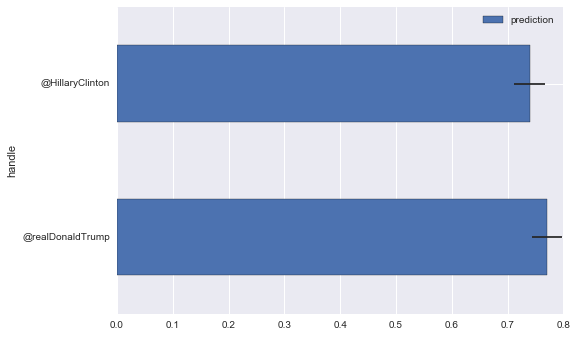

In [97]:
sentiment_pd.plot(x='handle', y='prediction', xerr='err', kind='barh');

But let's examine some "negative" tweets by Trump

In [98]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@realDonaldTrump').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review='Leaving West Palm Beach, Florida now - heading to St. Augustine for a 3pm rally. Will be in Tampa at 7pm - join me:… https://t.co/eLunEQRxZq'),
 Row(review="'The Clinton Foundation’s Most Questionable Foreign Donations'\n#PayToPlay #DrainTheSwamp\nhttps://t.co/IkeqMRjX5z"),
 Row(review='Why has nobody asked Kaine about the horrible views emanated on WikiLeaks about Catholics? Media in the tank for Clinton but Trump will win!'),
 Row(review='Major story that the Dems are making up phony polls in order to suppress the the Trump . We are going to WIN!'),
 Row(review='Thank you Naples, Florida! Get out and VOTE #TrumpPence16 on 11/8. \nLets #MakeAmericaGreatAgain! \nFull Naples rally… https://t.co/5ZbteSJ00K')]

And Clinton

In [99]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@HillaryClinton').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review='When Trump trivializes the sacrifice of our military and veterans, he makes it clear: He has no idea what service t… https://t.co/taRFZh6Ny5'),
 Row(review='Good question. https://t.co/wrd7SUI4cI https://t.co/Gpio1LA5Z8'),
 Row(review='Last night, Trump called a military effort to push terrorists out of Mosul a “total disaster.”\n\nThat’s dangerous. https://t.co/1MzyauM3Nw'),
 Row(review='RT @dougmillsnyt: .@SenWarren with @HillaryClinton during a campaign rally at Saint Anselm College in Manchester, NH https://t.co/ZsCfgVPKoz'),
 Row(review='"Donald Trump aggressively disrespects more than half the people in this country.” —@ElizabethForMA https://t.co/Lvsb5mkLSt')]

As you can see, there are lots of room for improvement.

## Part 2: Test yourself

1. From the IMDB dataframe (`imdb_reviews_df`), compute the average review length between positive and negative reviews. Hint: use the spark sql function `length`. In particular, as we imported the funcions with the name `fn` (using `from pyspark.sql import function as fn`), use `fn.length` with the name of the column.
2. In the IMDB review database, are positive reviews longer than negative reviews?
3. Using the sentiment dataframe `sentiments_df`, find the imdb reviews with the most number of negative words. __Hint__: You need to tokenize the `review` field in `imdb_review_df` and then join with `sentiments_df`. Finally, perform selection and summary query
4. Similar to 3, find the imdb review with the most number of positive words.

# Part 3: On our own

1) Using the best model fitted (`best_model`), estimate the generalization error in the testing set (`testing_df`)

2) One way of analyzing what is wrong with a model is to examine when they fail the hardest. In our case, we could do this by looking at cases in which logistic regression is predicting with high probability a positive sentiment when in fact the actual sentiment is negative. 

To extract the probability of positive sentiment, however, we must extract it from the prediction with a custom function.

In [100]:
from pyspark.sql import types

def probability_positive(probability_column):
    return float(probability_column[1])
func_probability_positive = fn.udf(probability_positive, types.DoubleType())

prediction_probability_df = best_model.transform(validation_df).\
    withColumn('probability_positive', func_probability_positive('probability')).\
    select('id', 'review', 'score', 'probability_positive')
prediction_probability_df.show()

+---------+--------------------+-----+--------------------+
|       id|              review|score|probability_positive|
+---------+--------------------+-----+--------------------+
|    neg_1|Robert DeNiro pla...|  0.0| 0.06587158723273108|
|neg_10023|Shame on Yash Raj...|  0.0|0.009391984685694108|
|neg_10032|The storyline was...|  0.0|0.014166856725052536|
|neg_10049|I love the freque...|  0.0| 0.43207946659537233|
|neg_10140|This movie should...|  0.0|  0.3240853568563492|
|neg_10179|This movie is a d...|  0.0|  0.3965396032278934|
|  neg_102|My girlfriend onc...|  0.0|  0.1672654011976563|
| neg_1026|Wow. I do not thi...|  0.0|0.009696097987398388|
|neg_10260|This movie was te...|  0.0|0.031003726981102722|
|neg_10370|I regret every si...|  0.0|  0.6504615507599262|
|neg_10392|I'm not going to ...|  0.0|7.405368733500202E-4|
|neg_10404|This, the direct-...|  0.0| 0.08210968623231926|
|neg_10415|2 stars out of a ...|  0.0|0.015189026075388143|
|neg_10446|B movie at best. ...|  0.0| 0

Analyze the worst predictions that are __very__ wrong and suggest some ways of improving the model. __Hint__: Do a query that would get the highest `probability_positive` values for cases where `score` is `0`, and vice versa.

3) Using the best model (`best_model`), predict the sentiment of the following sentences.

a) "Make America great again"

b) "Cats are not always the best companion"

c) "This sentence is not a sentence"